In [1]:
import open3d as o3d
from PyQt5.QtWidgets import QFileDialog, QWidget, QApplication
QApp = QApplication([])
QWidget = QWidget()
import os
import pickle
import numpy as np

from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


QSettings::value: Empty key passed
QSettings::value: Empty key passed


Load map

In [2]:
# Load ply map into open3d
world_file = QFileDialog.getOpenFileName(QWidget, 'Open file', "/home/junge/Documents/mesh_map/island_boy2.ply")[0]
if not os.path.isfile(world_file):
    raise FileNotFoundError("World file not found.")
world = o3d.io.read_triangle_mesh(world_file)
print("World loaded from file: ", world_file)
print("World has normals: ", world.has_triangle_normals(), "\nWorld has vertex normals: ", world.has_vertex_normals())
# Check if world triangles has normals
if not world.has_triangle_normals():
    print("Computing normals")
    # Compute normals
    world.compute_triangle_normals()
else:
    print("World has normals")

# Visualize world
#o3d.visualization.draw_geometries([world])

World loaded from file:  /home/junge/Documents/mesh_map/island_boy2.ply
World has normals:  False 
World has vertex normals:  True
Computing normals


In [3]:
def get_localization_data(file_path):

	with open(file_path, "rb") as f:
		data = pickle.load(f)

	print(len(data))

	orientations = []
	positions = []
	timesteps = []
	for msg in data:
		positions.append(msg[0])
		orientations.append(msg[1])
		timesteps.append(msg[2])


	localization_dict = {"orientations" : orientations, "positions" : positions, "timesteps" : timesteps}
	return localization_dict

file_path = QFileDialog.getOpenFileName(QWidget, 'Open file', "/home/junge/master_ws/src/Danitech-master/lmao/lmao/localizer_positions3.pkl")[0]
localization_dict = get_localization_data(file_path)

Qt: Session management error: networkIdsList argument is NULL


126


In [4]:
# Create lineset from positions
# Create lineset [[0,1], [1,2], [2,3], ...]
def create_lineset(positions, color):
    lines = []
    for i in range(len(positions)-1):
        lines.append([i, i+1])
    lineset = o3d.geometry.LineSet()
    lineset.points = o3d.utility.Vector3dVector(positions)
    lineset.lines = o3d.utility.Vector2iVector(lines)
    lineset.colors = o3d.utility.Vector3dVector([color for i in range(len(lines))])
    return lineset


In [5]:
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr
# Load all messages on topic /wagon/base_link_pose_gt

def load_from_bag(bag_file, topic):
    gt_positions = []
    gt_orientations = []
    clock = []
    with Reader(bag_file) as reader:
        #for connection in reader.connections:
            #print(connection.topic, connection.msgtype)
        for connection, timestamp, rawdata in reader.messages():
            if connection.topic == topic:
                msg = deserialize_cdr(rawdata, connection.msgtype)
                #print(msg.header.frame_id)
                #print(msg.pose.pose.position.x)
                gt_positions.append([msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.position.z])
                gt_orientations.append([msg.pose.pose.orientation.x, msg.pose.pose.orientation.y, msg.pose.pose.orientation.z, msg.pose.pose.orientation.w])
                clock.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)

    return gt_positions, gt_orientations, clock

bag_file = QFileDialog.getExistingDirectory(QWidget, 'Open file', "/home/junge/Documents/bags/island_boy_to_rule_them_all")
print("Bag file: ", bag_file)
gt_positions, gt_orientations, gt_clock = load_from_bag(bag_file, '/wagon/base_link_pose_gt')

bag_file = QFileDialog.getExistingDirectory(QWidget, 'Open file', "/home/junge/Documents/bags/montecarlo_dataset/mesh_world")
print("Bag file: ", bag_file)
mapping_positions, _, _ = load_from_bag(bag_file, '/wagon/base_link_pose_gt')


Bag file:  /home/junge/Documents/bags/island_boy_to_rule_them_all
Bag file:  /home/junge/Documents/bags/montecarlo_dataset/mesh_world


Mapping file:  /home/junge/Documents/bags/island_boy_2_gt.pkl
[Open3D INFO]   -- Mouse view control --
[Open3D INFO]     Left button + drag         : Rotate.
[Open3D INFO]     Ctrl + left button + drag  : Translate.
[Open3D INFO]     Wheel button + drag        : Translate.
[Open3D INFO]     Shift + left button + drag : Roll.
[Open3D INFO]     Wheel                      : Zoom in/out.
[Open3D INFO] 
[Open3D INFO]   -- Keyboard view control --
[Open3D INFO]     [/]          : Increase/decrease field of view.
[Open3D INFO]     R            : Reset view point.
[Open3D INFO]     Ctrl/Cmd + C : Copy current view status into the clipboard.
[Open3D INFO]     Ctrl/Cmd + V : Paste view status from clipboard.
[Open3D INFO] 
[Open3D INFO]   -- General control --
[Open3D INFO]     Q, Esc       : Exit window.
[Open3D INFO]     H            : Print help message.
[Open3D INFO]     P, PrtScn    : Take a screen capture.
[Open3D INFO]     D            : Take a depth capture.
[Open3D INFO]     O          

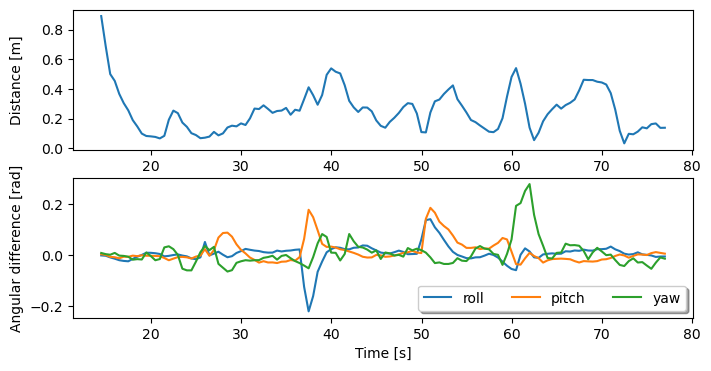

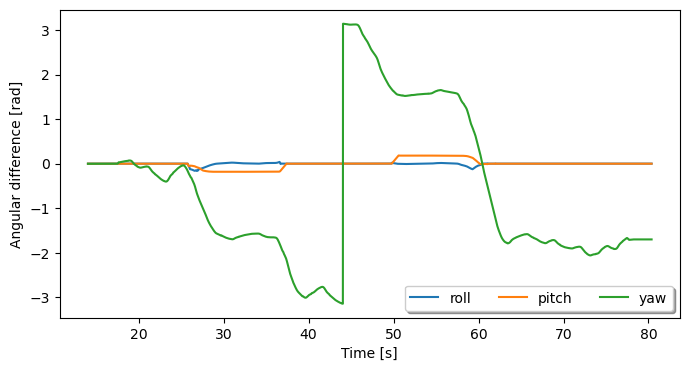

In [6]:
gt_lineset = create_lineset(gt_positions, [0,1,0])
localization_lineset = create_lineset(localization_dict["positions"], [1,0,0])
#mapping_lineset = create_lineset(mapping_positions, [0,0,1])
mapping_file = QFileDialog.getOpenFileName(QWidget, 'Open pkl file of mapping data', "/home/junge/Documents/bags/island_boy_2_gt.pkl")[0]
print("Mapping file: ", mapping_file)
# Load mapping data pickle
with open(mapping_file, "rb") as f:
    mapping_list = pickle.load(f)
mapping_lineset = create_lineset(mapping_list, [0,0,1])
# Visualize
o3d.visualization.draw_geometries([world, gt_lineset, localization_lineset, mapping_lineset])

dist = []
angular_difference = []

gt_positions = np.array(gt_positions)
loc_positions = np.array(localization_dict["positions"])

for i, pos in enumerate(loc_positions):
    idx = np.argmin(np.linalg.norm(gt_positions - pos, axis=1))
    dist.append(np.linalg.norm(gt_positions[idx] - pos))
    # Calculate difference in roll, pitch and yaw between gt and localization
    gt_rpy = R.from_quat(gt_orientations[idx]).as_euler('xyz', degrees=False)
    loc_rpy = R.from_quat(localization_dict["orientations"][i]).as_euler('xyz', degrees=False)
    # Get as three separate angles, respecting circularity
    roll_diff = np.arctan2(np.sin(gt_rpy[0] - loc_rpy[0]), np.cos(gt_rpy[0] - loc_rpy[0]))
    pitch_diff = np.arctan2(np.sin(gt_rpy[1] - loc_rpy[1]), np.cos(gt_rpy[1] - loc_rpy[1]))
    yaw_diff = np.arctan2(np.sin(gt_rpy[2] - loc_rpy[2]), np.cos(gt_rpy[2] - loc_rpy[2]))
    angular_difference.append([roll_diff, pitch_diff, yaw_diff])

angular_difference = np.array(angular_difference)

fig, ax = plt.subplots(2,1)

# Plot distance vs time
ax[0].plot(localization_dict["timesteps"], dist)
ax[0].set_ylabel("Distance [m]")

# Set width and height of plot
width = 8
height = 4
fig.set_figwidth(width)
fig.set_figheight(height)

# Plot angular difference vs time
ax[1].plot(localization_dict["timesteps"], angular_difference[:,0], label="roll")
ax[1].plot(localization_dict["timesteps"], angular_difference[:,1], label="pitch")
ax[1].plot(localization_dict["timesteps"], angular_difference[:,2], label="yaw")

# Vertically align y labels on plot 0 and 1
fig.align_ylabels()

# Place legend horizontally
ax[1].legend(loc='lower right', ncol=3, fancybox=True, shadow=True)

ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Angular difference [rad]")

plt.show()


gt_rpy = R.from_quat(gt_orientations).as_euler('xyz', degrees=False)
# Plot gt roll, pitch and yaw in a single plot
plt.plot(gt_clock, gt_rpy[:,0], label="roll")
plt.plot(gt_clock, gt_rpy[:,1], label="pitch")
plt.plot(gt_clock, gt_rpy[:,2], label="yaw")
plt.legend(loc='lower right', ncol=3, fancybox=True, shadow=True)
plt.xlabel("Time [s]")
plt.ylabel("Angular difference [rad]")
plt.gcf().set_figwidth(width)
plt.gcf().set_figheight(height)
plt.show()

0th index is x rays, 0th element is y particles


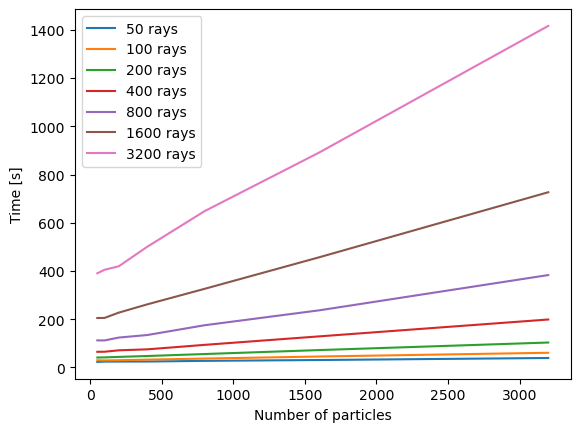

In [7]:
# Load times from test_data/times.txt
times = np.zeros((8,8))
times[0, :] = [np.nan, 50, 100, 200, 400, 800, 1600, 3200]
times[1:, 0] = [50, 100, 200, 400, 800, 1600, 3200]
with open("/home/junge/master_ws/src/Danitech-master/lmao/lmao/test_data/times.txt", "r") as f:
    # "Time for x rays and y particles: z"
    for line in f:
        line = line.split()
        x = int(line[2])
        x = times[:,0].tolist().index(x)
        y = int(line[5])
        y = times[0,:].tolist().index(y)
        times[x,y] = float(line[7])
    print("0th index is x rays, 0th element is y particles")
times = np.array(times)

# Plot times as a line
plt.plot(times[0, 1:], times[1:, 1:])
plt.xlabel("Number of particles")
plt.ylabel("Time [s]")
plt.legend(["50 rays", "100 rays", "200 rays", "400 rays", "800 rays", "1600 rays", "3200 rays"])
# set y log scale
plt.show()

